In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from IPython import display
%matplotlib inline


from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report, roc_auc_score, auc

## Investigation

In [51]:
data = pd.read_csv("../data/train.csv")
data.y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

Значит имеем задачу классификации, классы не сбалансированы. 

In [4]:
from sklearn.cross_validation import KFold, train_test_split

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
kfold = KFold(15, 3)

In [6]:
for idx in kfold:
    print(idx)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([0, 1, 2, 3, 4]))
(array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14]), array([5, 6, 7, 8, 9]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14]))


In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf = RandomForestClassifier(100)

In [134]:
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
rf_pred = rf.predict_proba(X_te)

In [136]:
log_loss(y_te, rf_pred)

0.3163935969124363

In [137]:
accuracy_score(y_te, rf_pred[:,0] < 0.5)

0.8664259927797834

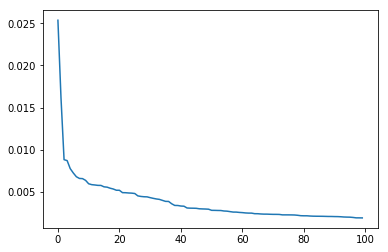

In [138]:
plt.plot(sorted(rf.feature_importances_)[::-1][:100])
plt.show()

In [141]:
rf_feauture_mask = rf.feature_importances_ > 0.002

In [142]:
rf_feauture_mask.sum()

93

In [9]:
X = data[data.columns[:-1]].values
y = data.y.values

In [10]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [11]:
class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}

In [12]:
class_weights

{0.0: 0.27898550724637683, 1.0: 0.7210144927536232}

In [54]:
from keras.layers import Dense

In [52]:
class WeightLayer:
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out                

In [53]:
class DFS:
    def __init__(self, name, input_shape, dense_sizes = [256, 256]):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.weight_layer = WeightLayer(input_shape, 'wl')

            self.dense_array = [Dense(x, activation=tf.nn.relu) for x in dense_sizes] + [Dense(2, activation=None)]
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                weight_layer_out = self.weight_layer(inp)
                next_var = weight_layer_out
                for layer in self.dense_array:
                    next_var = layer(next_var)
                
                logits = next_var
                out = tf.nn.softmax(logits)
        return logits, out

    def get_weighted_layer_regularization_term(self, alpha):
        with tf.variable_scope("weighted_layer_regularization"):
            return (1-alpha) * tf.reduce_sum(tf.abs(self.weight_layer.w)) +\
                    alpha * tf.reduce_sum(tf.square(self.weight_layer.w))
        
    def get_dense_layers_regularization_term(self, alpha):
        with tf.variable_scope("dense_layers_regularization"):
            r_term = 0
            for layer in self.dense_array:
                r_term += (1-alpha) * tf.reduce_sum(tf.abs(layer.weights[0])) +\
                            alpha * tf.reduce_sum(tf.square(layer.weights[0]))

            return r_term

In [126]:
class NNexperiment:
    def __init__(self, name, feature_mask):
        self.name = name
        self.session = tf.Session()
        self.feature_mask = feature_mask
        self.n_features = self.feature_mask.sum()
        
    def _initialize_network(self):
        with tf.variable_scope(self.name) as net_scope:
            ## Initialize network
            self.inp = tf.placeholder(tf.float32, [None, self.n_features])
            self.dfs = DFS(name + "_DFS", n_features)
            self.logits, self.out = self.dfs(self.inp)

            ##Prepare target and loss weights
            self.target = tf.placeholder(tf.float32, [None])
            self.loss_weights = tf.placeholder(tf.float32, [None])

            ##Loss terms
            self.ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(self.target, tf.int32), 2),
                                                           logits,
                                                           weights=self.loss_weights)
            self.features_weights_regularization = 0.1 * self.dfs.get_weighted_layer_regularization_term(0.5)
            self.network_weights_regularization = 0.0002 * self.dfs.get_dense_layers_regularization_term(0.5)

            self.loss = self.ce_loss + self.features_weights_regularization + self.network_weights_regularization

            self.optimizer = tf.train.AdamOptimizer()
            self.train_step = optimizer.minimize(self.loss, var_list=tf.trainable_variables(self.name))

            self.session.run(tf.global_variables_initializer())
        
        self.net_scope = net_scope
            
    def _plot_graphs(self):
        f, (a1, a2) = plt.subplots(2,1,figsize = (10,10))
        display.clear_output(wait=True)
        a1.plot(self.train_ce_losses[2:], label='train ce')
        a1.plot(self.val_ce_losses[2:], label = 'val ce')

        a2.plot(self.val_auc_scores[2:], label='val_auc')

        plt.legend()
        plt.show()
        
        
    def run_experiment(self, X_tr, y_tr, X_te, y_te, max_epochs, b_s=40, plot=True):
        self._initialize_network()
        
        self.train_ce_losses = []
        self.val_ce_losses = []
        self.val_auc_scores = []

        for epoch in range(max_epochs):
            train_ce_loss = 0

            for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, b_s)):
                batch_weights = np.array([class_weights[y] for y in batch_y])
                
                batch_loss = sess.run([train_step, ce_loss],
                                      feed_dict={inp : batch_X[:,feature_mask],
                                                 target: batch_y,
                                                 loss_weights:batch_weights})

                train_ce_loss += batch_loss[1] * batch_X.shape[0]


            val_weights = np.array([class_weights[y] for y in y_te])
            val_ce_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te, loss_weights : val_weights})
            val_auc_score = roc_auc_score(y_te, sess.run(out,  feed_dict={inp : X_te[:,feature_mask]})[:,1])

            self.val_ce_losses.append(val_ce_loss)
            self.val_auc_scores.append(val_auc_score)
            self.train_ce_losses.append(train_ce_loss / X_tr.shape[0])


            if plot:
                self._plot_graphs()


            if epoch > 40:
                if np.argmin(np.array(self.val_ce_losses[-20:])) == 0:
                    print("early stop")
                    break


In [129]:
exp_1 = NNexperiment("322", feature_mask)

In [130]:
exp_1.run_experiment(X_tr, y_tr, X_te, y_te, 300)

ValueError: Tensor("322/one_hot:0", shape=(?, 2), dtype=float32) must be from the same graph as Tensor("test_9/DFS/dense_30/BiasAdd:0", shape=(?, 2), dtype=float32).

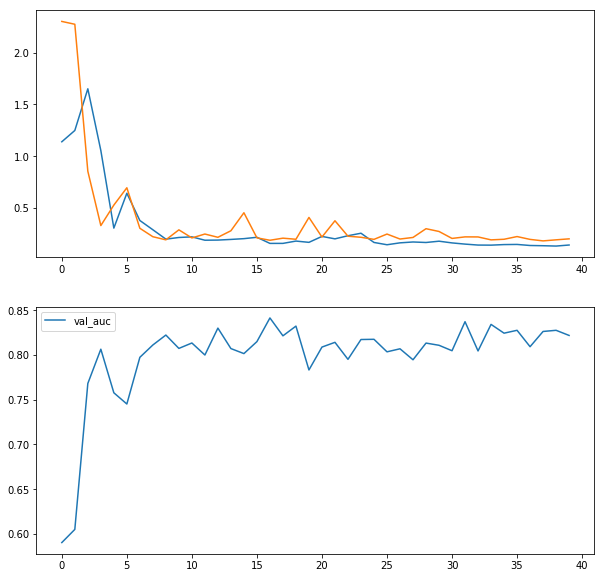

early stop


In [109]:
#def train_network(name, session, feature_mask):
name = 'test_9'
session = tf.Session()

n_features = feature_mask.sum()

with tf.variable_scope(name) as train_scope:
    ## Initialize network
    inp = tf.placeholder(tf.float32, [None, n_features])
    dfs = DFS("DFS", n_features)
    logits, out = dfs(inp)

    ##Prepare target and loss weights
    target = tf.placeholder(tf.float32, [None])
    loss_weights = tf.placeholder(tf.float32, [None])

    ##Loss terms
    ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(target, tf.int32), 2), logits, weights=loss_weights)
    features_weights_regularization = 0.1 * dfs.get_weighted_layer_regularization_term(0.5)
    network_weights_regularization = 0.0002 * dfs.get_dense_layers_regularization_term(0.5)

    loss = ce_loss + features_weights_regularization + network_weights_regularization

    optimizer = tf.train.AdamOptimizer()
    train_step = optimizer.minimize(loss, var_list=tf.trainable_variables(name))

    sess.run(tf.global_variables_initializer())



train_ce_loss = []
val_ce_loss = []
val_auc_scores = []

for epoch in range(epochs):
    curr_loss = 0

    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, 40)):
        batch_weights = np.array([class_weights[y] for y in batch_y])

        batch_loss = sess.run([train_step, ce_loss],
                              feed_dict={inp : batch_X[:,feature_mask],
                                         target: batch_y,
                                         loss_weights:batch_weights})

        curr_loss += batch_loss[1] * batch_X.shape[0]


    val_weights = np.array([class_weights[y] for y in y_te])
    val_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te, loss_weights : val_weights})
    val_auc = roc_auc_score(y_te, sess.run(out,  feed_dict={inp : X_te[:,feature_mask]})[:,1])

    val_ce_loss.append(val_loss)
    val_auc_scores.append(val_auc)
    train_ce_loss.append(curr_loss / X_tr.shape[0])

    
    f, (a1, a2) = plt.subplots(2,1,figsize = (10,10))
    display.clear_output(wait=True)
    a1.plot(train_ce_loss[2:], label='train ce')
    a1.plot(val_ce_loss[2:], label = 'val ce')
    
    a2.plot(val_auc_scores[2:], label='val_auc')

    plt.legend()
    plt.show()

    
    if epoch > 40:
        if np.argmin(np.array(val_losses[-20:])) == 0:
            print("early stop")
            break


    #zero_weights.append(np.abs(sess.run(weight_layer.w)).min())
        #print(batch_loss[1])

In [105]:
train_ce_loss

[]

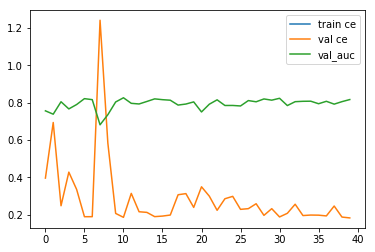

early stop


In [103]:
train_network("test6", sess, np.ones(X.shape[1]).astype(bool))

In [122]:
tf.reset_default_graph()
sess = tf.Session()

In [56]:
feature_mask = np.ones(X.shape[1]).astype(bool)
#feature_mask = rf_feauture_mask
n_features = feature_mask.sum()

inp = tf.placeholder(tf.float32, [None, n_features])#X.shape[1]])

dfs = DFS("DFS", n_features)

logits, out = dfs(inp)

In [57]:
target = tf.placeholder(tf.float32, [None])
loss_weights = tf.placeholder(tf.float32, [None])

In [58]:
ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(target, tf.int32), 2), logits, weights=loss_weights)

In [59]:
#regularization_term = 0.001 * tf.reduce_sum(tf.abs(weight_layer.w))

In [60]:
tf.trainable_variables()

[<tf.Variable 'DFS/wl/w:0' shape=(1524,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/kernel:0' shape=(1524, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/kernel:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/bias:0' shape=(2,) dtype=float32_ref>]

In [61]:
# weighted_layer_regularization = tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
# weighted_layer_regularization = 0.05 * weighted_layer_regularization

In [62]:
# regularization = 0#tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
# for layer in dfs.dense_array:
#     regularization += tf.reduce_sum(tf.abs(layer.weights[0])) + tf.reduce_sum(tf.square(layer.weights[0]))
# regularization = 0.0001 * regularization

In [63]:
loss = ce_loss + 0.1 * dfs.get_weighted_layer_regularization_term(0.5) +  0.0002 * dfs.get_dense_layers_regularization_term(0.5)

In [64]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss,var_list=tf.trainable_variables())

In [65]:
sess.run(tf.global_variables_initializer())

In [110]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [67]:
#sess.run(weighted_layer_regularization,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})

In [68]:
#sess.run(regularization,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})

In [70]:
def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [71]:
train_losses = []
train_ce = []
train_r1 = []
train_r2 = []

val_losses = []
val_x = []
n = 5
curr_loss = 0


In [72]:
epochs = 300

In [73]:
zero_weights = []

In [74]:
curr_loss = np.zeros(4)

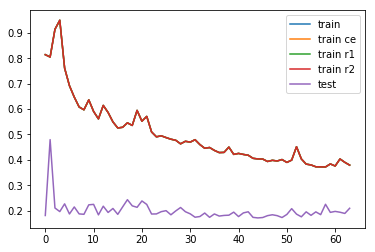

early stop


In [75]:
for epoch in range(epochs):
    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, 40)):
        batch_weights = np.array([class_weights[y] for y in batch_y])#.flatten()#.reshape(-1,1)

        batch_loss = sess.run([train_step, loss, loss, loss, loss],
                              feed_dict={inp : batch_X[:,feature_mask],
                                         target: batch_y,
                                         loss_weights:batch_weights})
        curr_loss += np.array(batch_loss[1:])
    
    curr_loss /= i
    train_losses.append(curr_loss[0])
    train_ce.append(curr_loss[1])
    train_r1.append(curr_loss[2])
    train_r2.append(curr_loss[3])
    
    curr_loss = np.zeros(4)
          
        
    val_weights = np.array([class_weights[y] for y in y_te])#.reshape(-1,1)
    val_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te, loss_weights : val_weights})
    val_losses.append(val_loss)
    
    display.clear_output(wait=True)
    plt.plot(train_losses[n:], label='train')
    plt.plot(train_ce[n:], label='train ce')
    plt.plot(train_r1[n:], label='train r1')
    plt.plot(train_r2[n:], label='train r2')
    
    plt.plot(val_losses[n:], label='test')
    plt.legend()
    plt.show()
    
    if epoch > 40:
        if np.argmin(np.array(val_losses[-20:])) == 0:
            print("early stop")
            break
            
    
    #zero_weights.append(np.abs(sess.run(weight_layer.w)).min())
        #print(batch_loss[1])

In [76]:
np.array(val_losses[-20:])  

array([0.17170314, 0.17321236, 0.18057978, 0.18412013, 0.18060762,
       0.17321223, 0.18536344, 0.2081416 , 0.18662906, 0.17604607,
       0.19564372, 0.18185163, 0.19551134, 0.18459737, 0.22531286,
       0.19351383, 0.1973642 , 0.1940897 , 0.18933259, 0.20970924],
      dtype=float32)

In [77]:
out_ = tf.nn.softmax(out)

In [78]:
pred = (sess.run(out, feed_dict={inp:X_te[:,feature_mask]}) > 0.5).astype(int)[:,1]

print(accuracy_score(y_te, pred))
print(f1_score(y_te, pred))

print(classification_report(y_te, pred))
#print(classification.zero_one_loss(y_te, pred))

mask = y_te < 0.5

print(accuracy_score(y_te[mask], pred[mask]), accuracy_score(y_te[np.logical_not(mask)], pred[np.logical_not(mask)]))

0.776173285198556
0.8597285067873303
             precision    recall  f1-score   support

        0.0       0.89      0.30      0.45        84
        1.0       0.76      0.98      0.86       193

avg / total       0.80      0.78      0.73       277

0.2976190476190476 0.9844559585492227


In [79]:
y_te

array([0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1.

In [80]:
pred.flatten().astype(float)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1.

In [81]:
importances = sess.run(dfs.weight_layer.w)

In [85]:
mask = importances.argsort()[::-1][:40]

array([ 364,  383,  424,  335,  407,  371,  323,  419,  290,  278,  289,
        273,  251,  257,  317,  314,  400,  305,  283,  272,  300,  691,
        665,  322,  318,  660,  969,  477,  231,  815,  624, 1043, 1089,
        448,  319,  834, 1214, 1447,   13,  100])

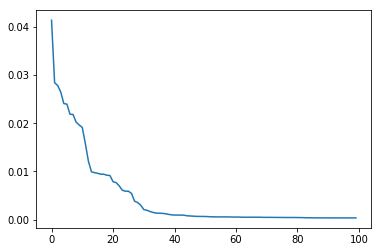

In [82]:
plt.plot(sorted(abs(importances))[::-1][:100])
plt.show()

In [486]:
sorted(abs(importances))[::-1][:60]

[0.043947864,
 0.043517802,
 0.035599638,
 0.03054874,
 0.029942408,
 0.024042096,
 0.022956392,
 0.022902142,
 0.022251979,
 0.021520147,
 0.020994166,
 0.016128628,
 0.015774554,
 0.013611497,
 0.013058648,
 0.011487326,
 0.010807884,
 0.01039926,
 0.0099691935,
 0.009339377,
 0.009335187,
 0.008031922,
 0.007830334,
 0.0077995034,
 0.007034731,
 0.0065056654,
 0.0057725166,
 0.0057263044,
 0.004963694,
 0.0046621305,
 0.0037396562,
 0.00345898,
 0.0028671261,
 0.0028366707,
 0.0022553024,
 0.0021701925,
 0.0016539771,
 0.0015091196,
 0.0010914928,
 0.00103581,
 0.0009411759,
 0.00087193074,
 0.0008696771,
 0.0008650388,
 0.0007399394,
 0.0006875464,
 0.000637955,
 0.0006377594,
 0.00063691364,
 0.00063677575,
 0.0006332269,
 0.00060557656,
 0.00058413035,
 0.00057808944,
 0.000575044,
 0.0005419304,
 0.00053618243,
 0.00049996027,
 0.0004913056,
 0.0004888583]